In [1]:
%matplotlib inline
import sys
sys.path.insert(0, "../..")

{{ badge }}

# Example 1. live-cell migration analysis using MAGIK

## 1. Setup

Imports the objects needed for this example.

In [18]:
import deeptrack as dt
from deeptrack.models.gnns.generators import GraphGenerator

import tensorflow as tf

import pandas as pd
import numpy as np

from deeptrack.extras import datasets

import logging
logging.disable(logging.WARNING)

## 2. Overview

In this example, we exemplify how to use [MAGIK](https://arxiv.org/abs/2202.06355) (Motion Analysis through GNN Inductive Knowledge) in its most natural application, trajectory linking. We will analyze a live cell migration experiment and address practical implications of using MAGIK (Data courtesy of Sergi Masó Orriols, [the QuBI lab](https://mon.uvic.cat/qubilab/)).

One of the main impediments when using deep learning methods is the availability of a suitable dataset, especially intended for the problem to be solved. Particularly for trajectory linking tasks, the absence of datasets is more notorious.

Here, we will demonstrate how to analyze a cell migration experiment without ground truths, exploiting the adaptive nature of MAGIK! We will train MAGIK using the BF-C2DL-MuSC dataset provided by the sixth edition of the Cell Tracking Challenge and evaluate the trained model on our data (see the schematic image below). 

Importantly, these two datasets share similarities in cell movement. By learning the movement dynamics of Mouse muscle stem cells, MAGIK extrapolates its inference to our cells without loss of precision.


<p align="center">
    <img src="assets/overview.png" alt="Overview" style="width:50%;"/>
</p>

## 2. Defining the dataset

### 2.1 Defining the training set

In [3]:
# Download the BF-C2DL-MuSC dataset
datasets.load("BFC2Cells")

Download Complete!
Extracting files...
Done
Cleaning up...
...OK!


MAGIK models the objects’ motion and physical interactions using a graph representation. Graphs can define arbitrary relational structures between nodes connecting them pairwise through edges. In MAGIK, each node describes an object detection at a specific time:


In [4]:
nodesdf = pd.read_csv("datasets/BFC2DLMuSCTra/nodesdf.csv")

# normalize centroids between 0 and 1
nodesdf.loc[:, nodesdf.columns.str.contains("centroid")] = (
    nodesdf.loc[:, nodesdf.columns.str.contains("centroid")]
    / np.array([1000.0, 1000.0])
)

# display the first 20 rows of the dataframe
nodesdf.head(20)


,label,centroid-0,centroid-1,frame,solution,set
0,5,0.271,0.568,0,0.0,0
1,8,0.171,0.492,0,0.0,0
2,9,0.860,0.623,0,0.0,0
3,11,0.742,0.631,0,0.0,0
4,5,0.281,0.551,1,0.0,0
5,8,0.175,0.481,1,0.0,0
6,9,0.878,0.614,1,0.0,0
7,11,0.729,0.630,1,0.0,0
8,5,0.284,0.538,2,0.0,0
9,8,0.181,0.473,2,0.0,0


``nodesdf`` contains the following columns:

- ``label``: cell label. Only used during training.

- ``centroid-0``: x-centroid coordinate (normalized between 0 and 1).

- ``centroid-1``: y-centroid coordinate (normalized between 0 and 1).

- ``frame``: frame corresponding to the detection.

- ``solution``: node ground truth (ignored). only used for node classification/regression tasks.

- ``set``: Index of the video in the dataset. The first video in the dataset is set 0, the second is set 1, and so on. Useful if multiples videos are available.

Importantly, There are no intrinsic restrictions on the type or number of descriptors (e.g., location and morphological features, image-based quantitiesn) that can be encoded in the node representation. 
In this example, we have only used the position of the object to train the model.

if available, the relationship between cell labels must be specified. Especially if training for cases where there are cell divisions.

In [5]:
parenthood = pd.read_csv("datasets/BFC2DLMuSCTra/parenthood.csv")

# display the first 10 rows of the dataframe
parenthood.head(10)

,child,parent
0,3,1
1,4,1
2,5,3
3,8,3
4,9,4
5,11,4
6,12,8
7,14,8
8,16,5
9,17,5


For object linking, the aim of MAGIK is to prune the wrong edges while retaining the true connections, i.e., an edge-classification problem with a binary label (linked/unlinked). We thus define:

In [6]:
# Output type
_OUTPUT_TYPE = "edges"

In MAGIK, nodes are connected to spatio-temporal neighbors within a distance-based likelihood radius:

In [7]:
# Seach radius for the graph edges
radius = 0.2

Finally, Let's create a dummy feature to store our configuration for the graph generation process:

In [8]:
variables = dt.DummyFeature(
    radius=radius,
    output_type=_OUTPUT_TYPE,
    nofframes=3, # time window to associate nodes (in frames) 
)

## 3. Defining the network

MAGIK is defined, with binary crossentropy as loss function.

In [9]:
model = dt.models.gnns.MAGIK(
    dense_layer_dimensions=(64, 96,),      # number of features in each dense encoder layer
    base_layer_dimensions=(96, 96, 96),    # Latent dimension throughout the message passing layers
    number_of_node_features=2,             # Number of node features in the graphs
    number_of_edge_features=1,             # Number of edge features in the graphs
    number_of_edge_outputs=1,              # Number of predicted features
    edge_output_activation="sigmoid",      # Activation function for the output layer
    output_type=_OUTPUT_TYPE,              # Output type. Either "edges", "nodes", or "graph"
)

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss = 'binary_crossentropy',
    metrics=['accuracy'],
)

model.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 2)]    0                                            
__________________________________________________________________________________________________
node_ide1 (Dense)               (None, None, 64)     192         input_1[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 multiple             0           node_ide1[0][0]                  
                                                                 edge_ide1[0][0]                  
                                                                 node_ide2[0][0]                  
                                                                 edge_ide2[0][0]       

## 4. Training the network

if ``_LOAD_MODEL`` is set to ``False``, we train the model using the BF-C2DL-MuSC dataset. `GraphGenerator` creates the graph representation from the detections and returns a continuous generator that asynchronously generates graphs during training.

In [10]:
_LOAD_MODEL = True

if _LOAD_MODEL:
    print("Loading model...")
    model.load_weights("datasets/BFC2DLMuSCTra/MAGIK.h5")
else:
    generator = GraphGenerator(
        nodesdf=nodesdf,
        properties=["centroid"],
        parenthood=parenthood,
        min_data_size=511,
        max_data_size=512,
        batch_size=8,
        **variables.properties()
    )
    
    with generator:
        model.fit(generator, epochs=10)

Loading model...


## 5. Evaluating the network

Now, let's download our dataset.

In [11]:
# Download the BF-C2DL-MuSC dataset
datasets.load("CellMigData")

Download Complete!
Extracting files...
Done
Cleaning up...
...OK!


We previously detected the position of the cells in each frame of the dataset using LodeSTAR and stored them in ``test_nodesdf``:

In [17]:
test_nodesdf = pd.read_csv("datasets/CellMigDataset/nodesdf.csv")
test_nodesdf.pop("Unnamed: 0")

# display the first 20 rows of the dataframe
test_nodesdf.head(20)

,centroid-0,centroid-1,frame,label,set,solution
0,0.025332,0.554650,0,0,0,0
1,0.039965,0.632138,0,0,0,0
2,0.074271,0.025885,0,0,0,0
3,0.081770,0.501343,0,0,0,0
4,0.109037,0.082098,0,0,0,0
5,0.120363,0.106404,0,0,0,0
6,0.134262,0.879869,0,0,0,0
7,0.167355,0.700103,0,0,0,0
8,0.185564,0.621800,0,0,0,0
9,0.193648,0.732335,0,0,0,0


Compute predictions for the test set:

In [13]:
pred, gt, scores, graph = dt.models.gnns.get_predictions(
    test_nodesdf, ["centroid"], model, variables
)

  0%|          | 0/1 [00:00<?, ?it/s]

Creating graph edges...


100%|██████████| 1/1 [00:07<00:00,  7.31s/it]


Crate dataframe from results:

In [14]:
edges_df, nodes, _ = dt.models.gnns.df_from_results(pred, gt, scores, graph)

# display the first 10 rows of the dataframe
edges_df.head(10)

,frame_x,frame_y,node_x,node_y,gt,prediction,score,frame_diff
0,0.0,1.0,0.0,79.0,1.0,1.0,0.966341,1.0
1,0.0,1.0,0.0,80.0,1.0,0.0,0.011437,1.0
2,0.0,1.0,0.0,82.0,1.0,0.0,0.010089,1.0
3,0.0,1.0,0.0,87.0,1.0,0.0,0.000061,1.0
4,0.0,1.0,1.0,79.0,1.0,0.0,0.005532,1.0
5,0.0,1.0,1.0,80.0,1.0,1.0,0.992297,1.0
6,0.0,1.0,1.0,82.0,1.0,0.0,0.000746,1.0
7,0.0,1.0,1.0,86.0,1.0,0.0,0.000180,1.0
8,0.0,1.0,1.0,87.0,1.0,0.0,0.000444,1.0
9,0.0,1.0,1.0,88.0,1.0,0.0,0.000061,1.0


Compute trajectories, and filter out trajectories less than 8 frames long:

In [15]:
# Get trajectories from results
traj = dt.models.gnns.get_traj(edges_df, th = 8)

Display results:

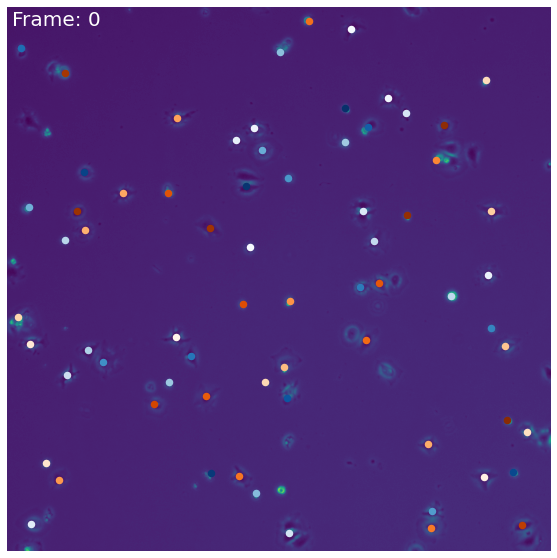

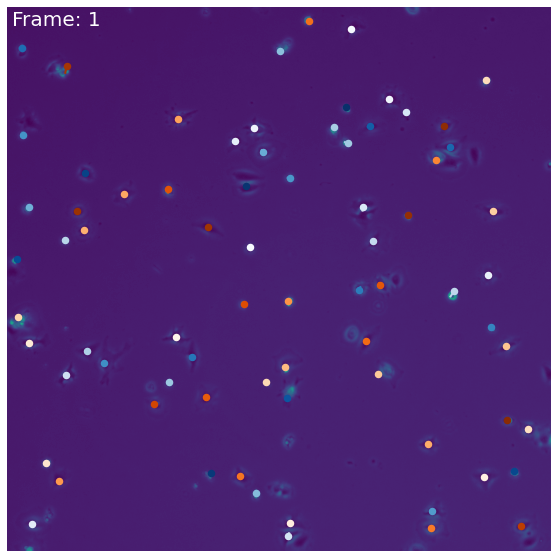

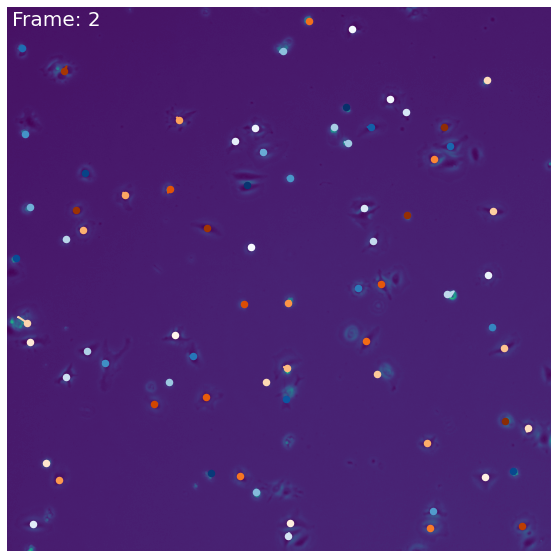

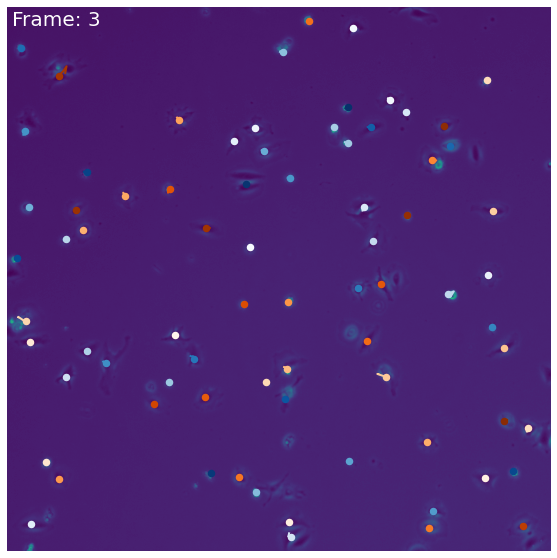

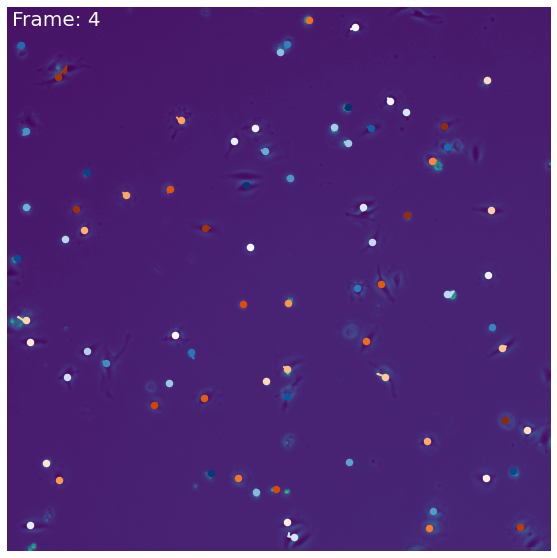

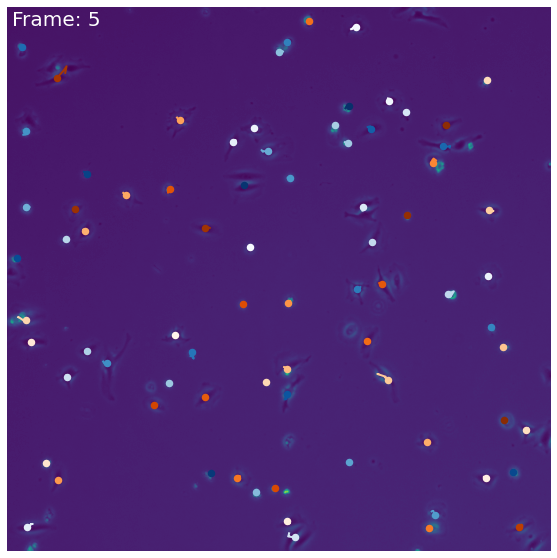

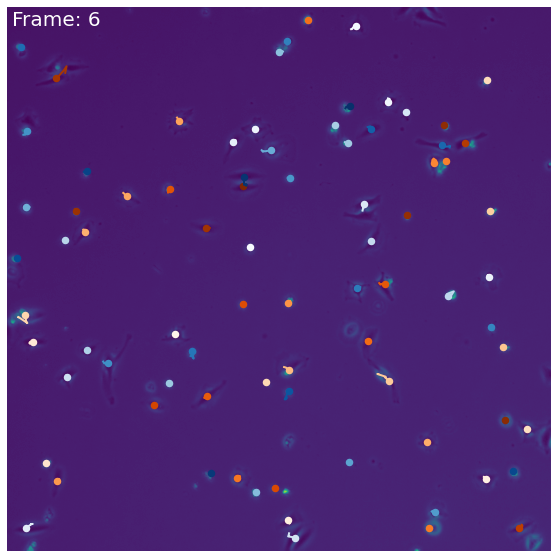

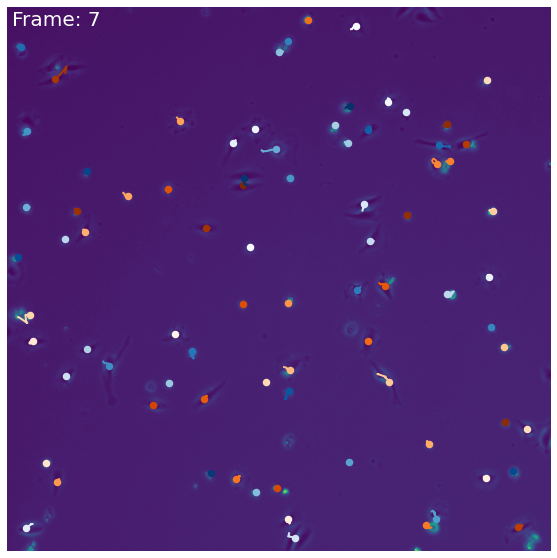

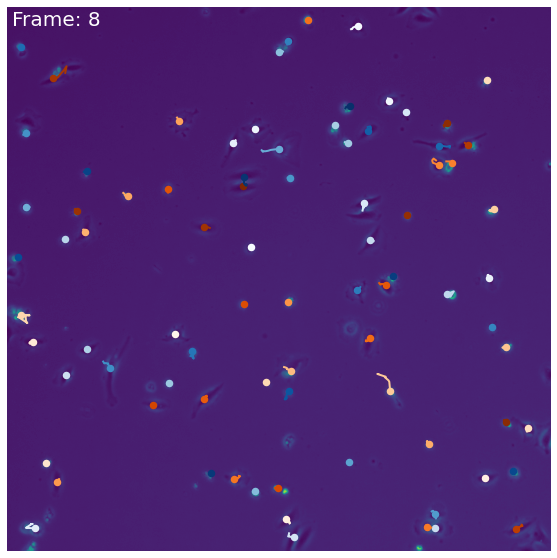

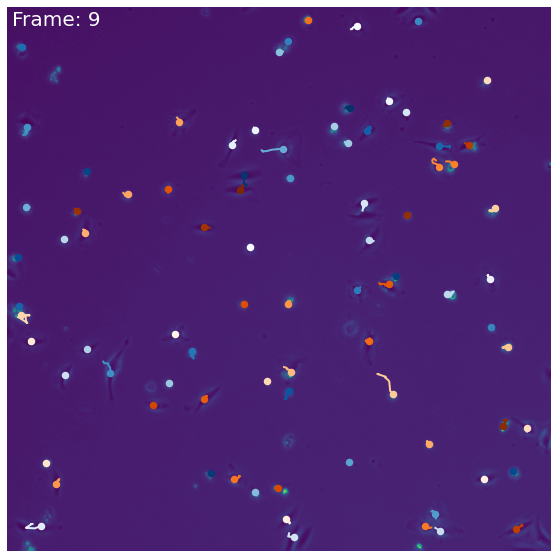

In [16]:
import glob
import cv2

import matplotlib.pyplot as plt

frames = glob.glob("datasets/CellMigDataset/images/*.tif")[0:10]

for f, frame in enumerate(frames):
    img = cv2.imread(frame, -1)

    fig = plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.text(10, 40, "Frame: " + str(f), fontsize=20, c="white")
    plt.axis("off")

    for i, (t, c) in enumerate(traj):
        detections = nodes[t][(nodes[t, 0] <= f) & (nodes[t, 0] >= f - 10), :]

        if (len(detections) == 0) or (np.max(nodes[t, 0]) < f):
            continue

        plt.plot(detections[:, 2] * 1200, detections[:, 1] * 1200, color = c, linewidth=2)
        plt.scatter(detections[-1, 2] * 1200, detections[-1, 1] * 1200, linewidths=1.5, c = c)
    
    plt.show()